In [4]:
from sentence_transformers import SentenceTransformer
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct
import uuid
import matplotlib.pyplot as plt
import numpy as np
from difflib import SequenceMatcher 
import seaborn as sns
import pandas as pd

In [5]:
client = QdrantClient("http://localhost:6333")
model = SentenceTransformer("all-MiniLM-L6-v2")

In [6]:
client.delete_collection(collection_name="documents")
client.recreate_collection(
    collection_name="documents",
    vectors_config={
        "size": 384,            
        "distance": "Cosine"
    }
)

C:\Users\akank\AppData\Local\Temp\ipykernel_43456\1657813294.py:2: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


True

In [7]:
def insert_doc(doc_id, text, metadata):
    vector = model.encode(text).tolist()
    client.upsert(
        collection_name="documents",
        points=[{
            "id": str(uuid.uuid4()),
            "vector": vector,
            "payload": {**metadata, "text": text}
        }]
    )

In [8]:
def search_context(query, top_k=3, cutoff=0.55):
    vector = model.encode(query).tolist()
    search_result = client.search("documents", query_vector=vector, limit=top_k)
    result = [c for c in search_result if c.score > cutoff]
    return result

In [ ]:
# insert_doc("doc1", "Tesla stated in Q2 2023 that margins were under pressure.", {"source": "10Q_Q2_2023"})

In [9]:
import json

with open("./parsed_script.json", "r") as file:
    movie_dialogues = json.load(file)

print(movie_dialogues)


[{'doc_id': 'doc1', 'text': "CLOSE ON: A HOUSE-ARREST ANKLE BRACELET. CLINT BARTON (O.S.) Okay, you see where you're going? Let's work on how to get there. Pan up to find...CLINT BARTON, with his daughter, LILA, coaching her as she notches an arrow in her bow. CLINT BARTON(CONT'D) Okay, good...tip down...bow arm out...three fingers- LILA BARTON Why three? CLINT BARTON 'Cause two's not enough and four's too much- LAURA BARTON (O.S.) You guys want mustard or mayo, or both? CLINT TURNS.  IN THE FIELD BEHIND THEM, his wife, LAURA BARTON sets up a picnic as COOPER and NATHANIEL play soccer. LILA BARTON Who puts mayo on a hot dog? CLINT BARTON We'll both have mustard, hon! (to Lila) Okay.  Draw back, deep breath... She lets loose.  THUD!  HER ARROW HITS NEAR THE BULLS-EYE. CLINT BARTON(CONT'D) Good job, Hawkeye.  Go get your arrow. LAURA BARTON (O.S.) Enough murder practice!  Soup's on! CLINT BARTON One sec, babe.  Be right there! We're gonna kill some hot dogs. We're hungry. But when he tur

In [10]:
from tqdm import tqdm

for row in tqdm(movie_dialogues, desc="Inserting documents"):
    insert_doc(row["doc_id"], row["text"], {"source": row["source"]})

Inserting documents: 100%|███████████████████████████████████████████████████████████| 155/155 [00:13<00:00, 11.46it/s]


In [11]:
def build_prompt(query, contexts):
    context_text = ""
    if len(contexts) > 0 :
        context_text = "\n".join(f"{c.payload['text']} [source: {c.payload['source']}]" for c in contexts)
    return f"""
System: Use only the facts below to answer. If unsure, say 'I don't know.'
Facts:
{context_text}
User: {query}
"""

In [12]:
from openai import OpenAI
import os
api_key = os.getenv("OPENAI_API_KEY")

openai_client = OpenAI(api_key= api_key)

def query_llm(prompt):
    response = openai_client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=256
    )
    return response.choices[0].message.content

In [13]:
llm_input = "What did Tesla say about Q2?"
contexts = search_context(llm_input)
prompt = build_prompt(llm_input, contexts) # this is a RAG query
# prompt = built_prompt(llm_input, [])     # this is a non RAG query
print(query_llm(prompt))

C:\Users\akank\AppData\Local\Temp\ipykernel_43456\3229858389.py:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search("documents", query_vector=vector, limit=top_k)


I don't know.


In [ ]:
# print(query_llm("Tell me a good joke"))

In [14]:
from transformers import pipeline

nli = pipeline("text-classification", model="microsoft/deberta-large-mnli")

def verify_claim(claim, context):
    result = nli(f"{claim} </s> {context}")
    return result[0]['label']  # Should be 'ENTAILMENT' if valid

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


In [15]:
claim = "Tesla promised 30% margin in Q2"
context = "Tesla said margins were under pressure in Q2."
print(verify_claim(claim, context))  # EXPECTED: 'CONTRADICTION' or 'NEUTRAL'

CONTRADICTION


In [16]:
def score_response(claim, contexts):
   # verify_result = [verify_claim(claim, c.payload["text"]) for c in contexts]
    verify_result = []
    for i, c in enumerate(contexts):
        print(f"Verifying context {i+1}")
        verify_result.append(verify_claim(claim, c.payload["text"])) 
    support = sum(1 for r in verify_result if r == "ENTAILMENT")
    contradiction = sum(1 for r in verify_result if r == "CONTRADICTION")
    return {
        "supported": support,
        "contradicted": contradiction,
        "hallucination_score": contradiction / (support + 1)
    }

In [17]:
def fallback_handler(score_data):
    if score_data['hallucination_score'] > 0.5:
        return "⚠️ Potential hallucination. Would you like to rephrase?"
    return "✅ Looks good."

In [18]:
def tag_response(response, contexts):
    return {
        "answer": response,
        "sources": [(c.payload["source"], c.payload["text"]) for c in contexts],
        "model_version": "gpt-3.5-turbo",
        "verified": True
    }

In [19]:
prompt = "Who played finger football with Tony Stark?"
contexts_list = search_context(prompt) 

C:\Users\akank\AppData\Local\Temp\ipykernel_43456\3229858389.py:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search("documents", query_vector=vector, limit=top_k)


In [20]:
gpt_claim = query_llm(prompt)

In [21]:
score = score_response(gpt_claim, contexts_list)
print(score)
fallback_handler(score)

Verifying context 1
{'supported': 0, 'contradicted': 1, 'hallucination_score': 1.0}


'⚠️ Potential hallucination. Would you like to rephrase?'

In [22]:
def truthnet_query(user_input):
    print("Searching context")
    contexts = search_context(user_input) 
    print("Building prompt")
    prompt = build_prompt(user_input, contexts)  
    print("Asking GPT")
    answer = query_llm(prompt)
    print("Scoring response")
    score = score_response(answer, contexts) 
    print("tagging response")
    trace = tag_response(answer, contexts) 
    print("Handling Fallback")
    fallback_msg = fallback_handler(score)
    return {
        "question": user_input,
        "answer": answer,
        "score": score,
        "trace": trace,
        "fallback": fallback_msg
    }

In [23]:
def non_rag_query(user_input):
    print("Searching context")
    contexts = search_context(user_input) 
    print("Building prompt")
    prompt = build_prompt(user_input, []) 
    print("Asking GPT")
    answer = query_llm(prompt)
    print("Scoring response")
    score = score_response(answer, contexts) 
    print("tagging response")
    trace = tag_response(answer, contexts) 
    print("Handling Fallback")
    fallback_msg = fallback_handler(score)
    return {
        "question": user_input,
        "answer": answer,
        "score": score,
        "trace": trace,
        "fallback": fallback_msg
    }

In [24]:
import json

with open("questions.json", "r") as file:
    questions = json.load(file)
print(type(questions))
print(questions)

<class 'list'>
[{'question_1': 'What game are Tony Stark and Nebula playing aboard the Benatar?'}, {'question_2': 'What advice does Clint Barton give Lila about using three fingers while shooting an arrow?'}, {'question_3': 'What does Clint Barton say just before Lila disappears?'}, {'question_4': 'What does Tony Stark record in his helmet for Pepper while stranded in space?'}, {'question_5': 'What line does Tony say after finishing his recording and preparing to drift off?'}, {'question_6': 'How does Tony react when he sees Rocket for the first time?'}, {'question_7': "What is Thanos' answer when Nebula asks what he would do after completing his plan?"}, {'question_8': 'Who suggests using the Infinity Stones to bring everyone back?'}, {'question_9': 'What does Thor say after beheading Thanos?'}, {'question_10': "What does Natasha say when asked how she's handling an underwater earthquake?"}, {'question_11': 'What does Steve Rogers say is still out there, despite the state of the world

In [25]:
results = {}

for i in range(len(questions)):
    print(f"\nProcessing question number {i+1}")
    row = questions[int(i)] 
    key = f"question_{int(i) + 1}"  
    question = row[key]
    results[key] = truthnet_query(question)


Processing question number 1
Searching context
Building prompt
Asking GPT


C:\Users\akank\AppData\Local\Temp\ipykernel_43456\3229858389.py:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search("documents", query_vector=vector, limit=top_k)


Scoring response
Verifying context 1
Verifying context 2
tagging response
Handling Fallback

Processing question number 2
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
tagging response
Handling Fallback

Processing question number 3
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
tagging response
Handling Fallback

Processing question number 4
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
tagging response
Handling Fallback

Processing question number 5
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
Verifying context 2
tagging response
Handling Fallback

Processing question number 6
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
tagging response
Handling Fallback

Processing question number 7
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
Verifying context 2
Verifying context 3
t

In [26]:
results

{'question_1': {'question': 'What game are Tony Stark and Nebula playing aboard the Benatar?',
  'answer': 'Table-top football.',
  'score': {'supported': 0, 'contradicted': 0, 'hallucination_score': 0.0},
  'trace': {'answer': 'Table-top football.',
   'sources': [('INT. BENATAR, GALLEY - NIGHT',
     'TONY STARK and NEBULA play table-top football.  She wins. TONY (offering his hand) Good sport.  Have fun? Nebula studies his hand, confused.  Finally she shakes. NEBULA It was fun.'),
    ('INT. BENATAR, FLIGHT DECK - DAWN',
     "EVERYONE settles into their seats on the Benatar's flight deck.  STEVE WATCHES EARTH GROW SMALLER THROUGH THE WINDOW. CAROL DANVERS Trust me.  You get used to it. ROCKET looks around from the pilot's chair. ROCKET Okay, who here hasn't been to space? STEVE, NATASHA, and RHODEY half-raise their hands. ROCKET(CONT'D) Oh, you're gonna hate this. NEBULA Approaching jump in three, two... STEVE'S FINGERS TIGHTEN on the arm rest as...12 13EXT. BENATAR - DAWN WHOOSH! 

In [27]:
non_rag_results = {}

for i in range(len(questions)):
    print(f"\nProcessing question number {i+1}")
    row = questions[int(i)]  
    key = f"question_{int(i) + 1}"  
    question = row[key]
    non_rag_results[key] = non_rag_query(question)


Processing question number 1
Searching context
Building prompt
Asking GPT


C:\Users\akank\AppData\Local\Temp\ipykernel_43456\3229858389.py:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search("documents", query_vector=vector, limit=top_k)


Scoring response
Verifying context 1
Verifying context 2
tagging response
Handling Fallback

Processing question number 2
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
tagging response
Handling Fallback

Processing question number 3
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
tagging response
Handling Fallback

Processing question number 4
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
tagging response
Handling Fallback

Processing question number 5
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
Verifying context 2
tagging response
Handling Fallback

Processing question number 6
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
tagging response
Handling Fallback

Processing question number 7
Searching context
Building prompt
Asking GPT
Scoring response
Verifying context 1
Verifying context 2
Verifying context 3
t

In [28]:
non_rag_results

{'question_1': {'question': 'What game are Tony Stark and Nebula playing aboard the Benatar?',
  'answer': "I don't know.",
  'score': {'supported': 0, 'contradicted': 0, 'hallucination_score': 0.0},
  'trace': {'answer': "I don't know.",
   'sources': [('INT. BENATAR, GALLEY - NIGHT',
     'TONY STARK and NEBULA play table-top football.  She wins. TONY (offering his hand) Good sport.  Have fun? Nebula studies his hand, confused.  Finally she shakes. NEBULA It was fun.'),
    ('INT. BENATAR, FLIGHT DECK - DAWN',
     "EVERYONE settles into their seats on the Benatar's flight deck.  STEVE WATCHES EARTH GROW SMALLER THROUGH THE WINDOW. CAROL DANVERS Trust me.  You get used to it. ROCKET looks around from the pilot's chair. ROCKET Okay, who here hasn't been to space? STEVE, NATASHA, and RHODEY half-raise their hands. ROCKET(CONT'D) Oh, you're gonna hate this. NEBULA Approaching jump in three, two... STEVE'S FINGERS TIGHTEN on the arm rest as...12 13EXT. BENATAR - DAWN WHOOSH!  THE BENATAR

In [29]:
# Printing context score for each question with assigned threshold
for i in range(len(questions)):
    row = questions[int(i)] 
    key = f"question_{int(i) + 1}"
    question = row[key] 
    print([c.score for c in search_context(question)])

C:\Users\akank\AppData\Local\Temp\ipykernel_43456\3229858389.py:3: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = client.search("documents", query_vector=vector, limit=top_k)


[0.69170696, 0.55315906]
[0.58438885]
[0.5558171]
[0.5659056]
[0.6473696, 0.5650012]
[0.55716205]
[0.6765666, 0.6704394, 0.6504264]
[0.60702634]
[0.5833805, 0.56041074]
[0.55197203]
[]
[0.585224, 0.56485033]
[0.591058, 0.56967413]
[0.5568804]
[0.5713151]
[0.60130936, 0.58721673]
[0.67362165, 0.62441444, 0.5575673]
[0.6629702, 0.5721862]
[]
[0.60736424]
[0.6507116]
[0.59064716]
[0.6608141, 0.5950451, 0.58071285]
[0.62704265, 0.5632099]
[0.5723403]


In [30]:
# save results of RAG and Non-RAG
with open("results.json", "w") as f:
    json.dump(results, f, indent=2)

In [31]:
with open("non_rag_results.json", "w") as f:
    json.dump(non_rag_results, f, indent=2)

In [32]:
# Count correct answers
rag_correct = sum(1 for q in results.values() if q["fallback"] == "✅ Looks good.")
non_rag_correct = sum(1 for q in non_rag_results.values() if q["fallback"] == "✅ Looks good.")
print(f"RAG Correct: {rag_correct}/25 | Non-RAG Correct: {non_rag_correct}/25")

print("RAG Hallucinations:", 25-rag_correct) 
print("Non-RAG Hallucinations:", 25-non_rag_correct) 

RAG Correct: 17/25 | Non-RAG Correct: 15/25
RAG Hallucinations: 8
Non-RAG Hallucinations: 10


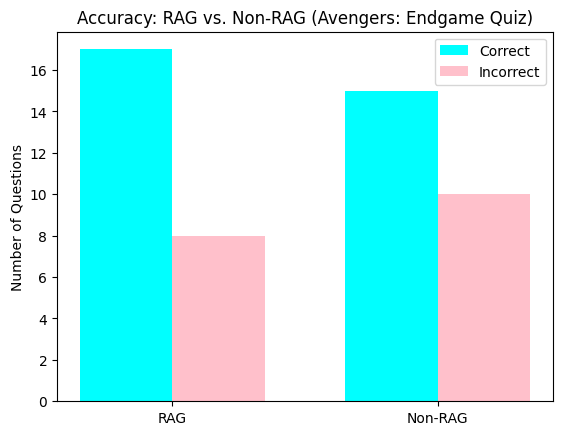

In [33]:
labels = ['RAG', 'Non-RAG']
correct = [rag_correct, non_rag_correct]
incorrect = [25 - rag_correct, 25 - non_rag_correct]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, correct, width, label='Correct', color='cyan')
rects2 = ax.bar(x + width/2, incorrect, width, label='Incorrect', color='pink')

ax.set_title('Accuracy: RAG vs. Non-RAG (Avengers: Endgame Quiz)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylabel('Number of Questions')
plt.show()

In [34]:
# Count of "I don't know" in Non-RAG vs RAG
non_rag_unknown = sum(1 for q in non_rag_results.values() if "I don't know." in q["answer"])
rag_unknown = sum(1 for q in results.values() if "I don't know." in q["answer"])

print(f"Non-RAG 'I don't know': {non_rag_unknown}/25")
print(f"RAG 'I don't know': {rag_unknown}/25")


Non-RAG 'I don't know': 19/25
RAG 'I don't know': 8/25


In [35]:
# Questions Where Non-RAG Failed But RAG Knew
for q_id, q_data in non_rag_results.items():
    if "I don't know." in q_data["answer"] and "I don't know." not in results[q_id]["answer"]:
        print(f"\nQuestion: {questions[int(q_id.split('_')[-1])-1][q_id]}")
        print(f"Non-RAG Answer: {q_data['answer']}")
        print(f"RAG Answer: {results[q_id]['answer']}")
        print(f"RAG Sources: {[c for c in results[q_id]['trace']['sources']]}")
        


Question: What game are Tony Stark and Nebula playing aboard the Benatar?
Non-RAG Answer: I don't know.
RAG Answer: Table-top football.
RAG Sources: [('INT. BENATAR, GALLEY - NIGHT', 'TONY STARK and NEBULA play table-top football.  She wins. TONY (offering his hand) Good sport.  Have fun? Nebula studies his hand, confused.  Finally she shakes. NEBULA It was fun.'), ('INT. BENATAR, FLIGHT DECK - DAWN', "EVERYONE settles into their seats on the Benatar's flight deck.  STEVE WATCHES EARTH GROW SMALLER THROUGH THE WINDOW. CAROL DANVERS Trust me.  You get used to it. ROCKET looks around from the pilot's chair. ROCKET Okay, who here hasn't been to space? STEVE, NATASHA, and RHODEY half-raise their hands. ROCKET(CONT'D) Oh, you're gonna hate this. NEBULA Approaching jump in three, two... STEVE'S FINGERS TIGHTEN on the arm rest as...12 13EXT. BENATAR - DAWN WHOOSH!  THE BENATAR WARPS, LEAPING INTO JUMP SPACE.")]

Question: What line does Tony say after finishing his recording and preparing to

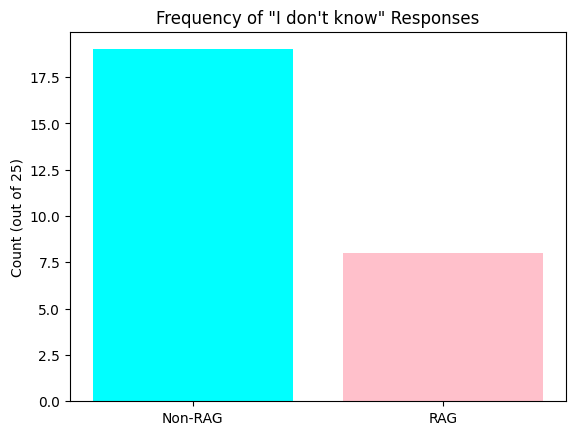

In [36]:
labels = ['Non-RAG', 'RAG']
unknown_counts = [non_rag_unknown, rag_unknown]

plt.bar(labels, unknown_counts, color=['cyan', 'pink'])
plt.title('Frequency of "I don\'t know" Responses')
plt.ylabel('Count (out of 25)')
plt.show()

### Evaluation

Both models hallucinated 8/25 answers for RAG and 10/25 for Non RAG, but RAG’s errors were more contextually plausible 
e.g, paraphrasing instead of guessing

By integrating retrieval, RAG reduces "I don’t know" responses by ~50% (from 19 to 8).
Example: Q18(What does Valkyrie say about Thor’s visits to New Asgard?) was answered correctly by RAG but missed by Non-RAG.

In my evaluation RAG has an edge over Non-RAG by pulling up retrieved context to answer more questions correctly (17 vs. 15) while reducing 'I don’t know' responses. However, both models hallucinated in 8 answers tells that retrieval alone isn’t foolproof.

In [37]:
google_answers = {
    "question_1": "Paper football",
    "question_2": "use three fingers",
    "question_3": "Good job, Hawkeye. Go get your arrow.",
    "question_4": "This thing on? Hey, Miss Potts Pep. If you find this recording, don't post it on social media. It's gonna be a real tear-jerker. I don't know if you're ever going to see these. I don't even know if you're, if you're still, Oh god, I hope so. Today is day 21, uh 22. You know, if it wasn't for the existential terror of staring into a void of space, I'd say I'm feeling better today. The infection's run its course, Thanks to the blue meanie back there. You'd love her. Very practical. Only a tiny bit sadistic. Some fuel cells were cracked during battle, but we figured out a way to reverse the ion charge to buy ourselves about 48 hours of time. But it's now dead in the water. We're 1000 light years from the nearest 7-11. Oxygen will run out tomorrow. And that'll be it. And Pep, I, I know I said no more surprises, but I was really hoping to pull off one last one. But it looks like, well you know what it looks like. Don't feel bad about this. I mean, if you grovel for a couple of weeks, and then move on with enormous guilt. I should probably lie down. Please know that when I drift off, I will think about you. Because it's always you.",
    "question_5": "Please know that when I drift off, I will think about you. Because it's always you.",
    "question_6": "mixture of surprise and initial confusion, coupled with his usual wit and sarcasm.",
    "question_7": "To the Garden",
    "question_8": "Ant-Man (Scott Lang)",
    "question_9": "I went for the head",
    "question_10": "we handle it by not handling it",
    "question_11": "hope is still out there.",
    "question_12": "You mess with time, it tends to mess back",
    "question_13": "I love you 3000",
    "question_14": "MIND, SPACE, TIME, POWER, REALITY, and SOUL",
    "question_15": "Endgame",
    "question_16": "best of both worlds",
    "question_17": "melted ice cream",
    "question_18": "We only see him once a month, when he comes for supplies",
    "question_19": "baseball glove",
    "question_20": "so like I can run one last sim before we pack it in for the night this time in the shape of a moious strip inverted please processing right give me the value of that particle factoring in spectral demp that'll take a second just a moment. and don't worry if it doesn't pan out i'm just kind of. model rendered shit shit",
    "question_21": "Noobmaster, hey, it's Thor again. You know, the God of Thunder? Listen, buddy, if you don't log off this game immediately, I am gonna fly over to your house, come down to that basement you're hiding in, rip off your arms and shove them up your butt! Oh, that's right, yes, go cry to your father, you little weasel!",
    "question_22": "We lost. All of us. We lost friends. We lost family. We lost a part of ourselves. Today, we have a chance to take it all back, and concludes it with, We're gonna win. Whatever it takes",
    "question_23": "severely weakened state",
    "question_24": "That's the front gate",
    "question_25": "Regular-Sized Man"
}


In [38]:
# Print all questions where RAG was marked as hallucination but matches Google's answer
print("False Negative Cases (RAG Correct but Marked as Hallucination):\n")
false_negatives = []
for q_id, q_data in results.items():
    rag_question = q_data["question"]
    rag_answer = q_data["answer"]
    fallback = q_data["fallback"]
    
    if fallback == "⚠️ Potential hallucination. Would you like to rephrase?":
        google_answer = google_answers.get(q_id, "")
        
        if google_answer.lower() in rag_answer.lower():
            print(f"Question ID: {q_id}")
            print(f"Question: {rag_question}")
            print(f"Google Truth: {google_answer}")
            print(f"RAG Answer: {rag_answer}")
            print("-" * 80)
            false_negatives.append((q_id, rag_answer, google_answer))

False Negative Cases (RAG Correct but Marked as Hallucination):

Question ID: question_2
Question: What advice does Clint Barton give Lila about using three fingers while shooting an arrow?
Google Truth: use three fingers
RAG Answer: Clint Barton advises Lila to use three fingers while shooting an arrow because two fingers are not enough and four fingers are too much.
--------------------------------------------------------------------------------
Question ID: question_7
Question: What is Thanos' answer when Nebula asks what he would do after completing his plan?
Google Truth: To the Garden
RAG Answer: Thanos' answer is always "To the Garden."
--------------------------------------------------------------------------------
Question ID: question_25
Question: What nickname does Rhodey give Scott Lang during the taco scene?
Google Truth: Regular-Sized Man
RAG Answer: Rhodey gives Scott Lang the nickname "Regular-Sized Man" during the taco scene.
-------------------------------------------

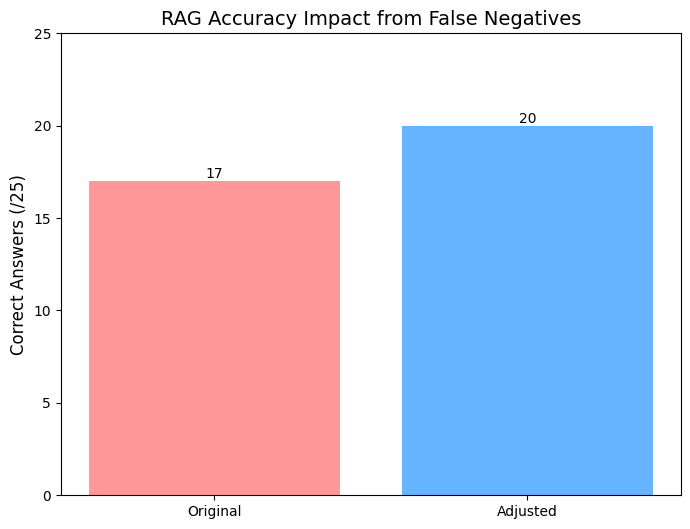

In [39]:
# Accuracy Impact Comparison 
original_correct = sum(1 for q in results.values() if q["fallback"] == "✅ Looks good.")
adjusted_correct = original_correct + len(false_negatives)

plt.figure(figsize=(8, 6))
bars = plt.bar(['Original', 'Adjusted'], 
               [original_correct, adjusted_correct],
               color=['#ff9999', '#66b3ff'])

plt.title("RAG Accuracy Impact from False Negatives", fontsize=14)
plt.ylabel("Correct Answers (/25)", fontsize=12)
plt.ylim(0, 25)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.show()

C:\Users\akank\AppData\Local\Temp\ipykernel_43456\306084579.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


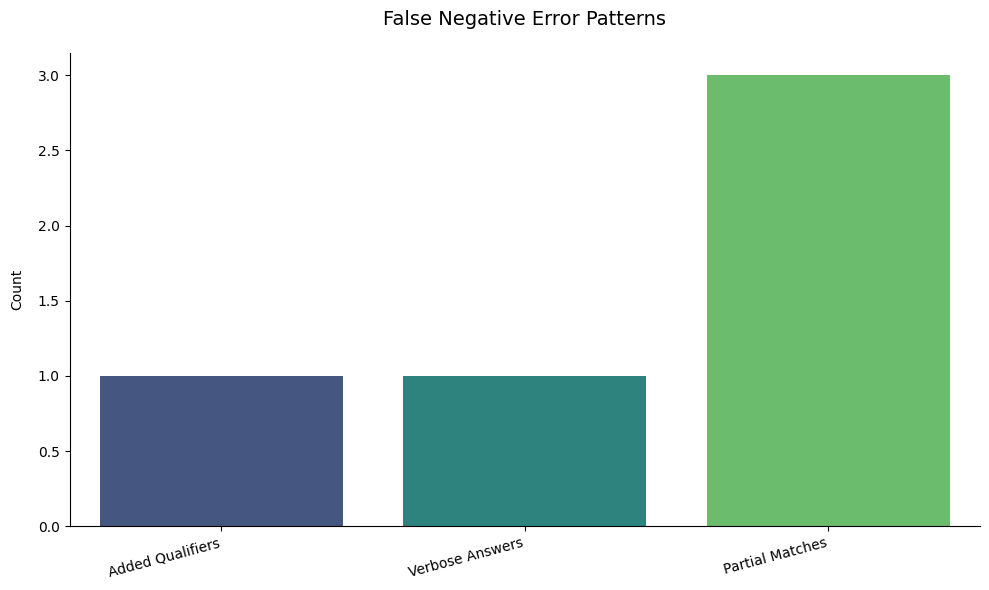

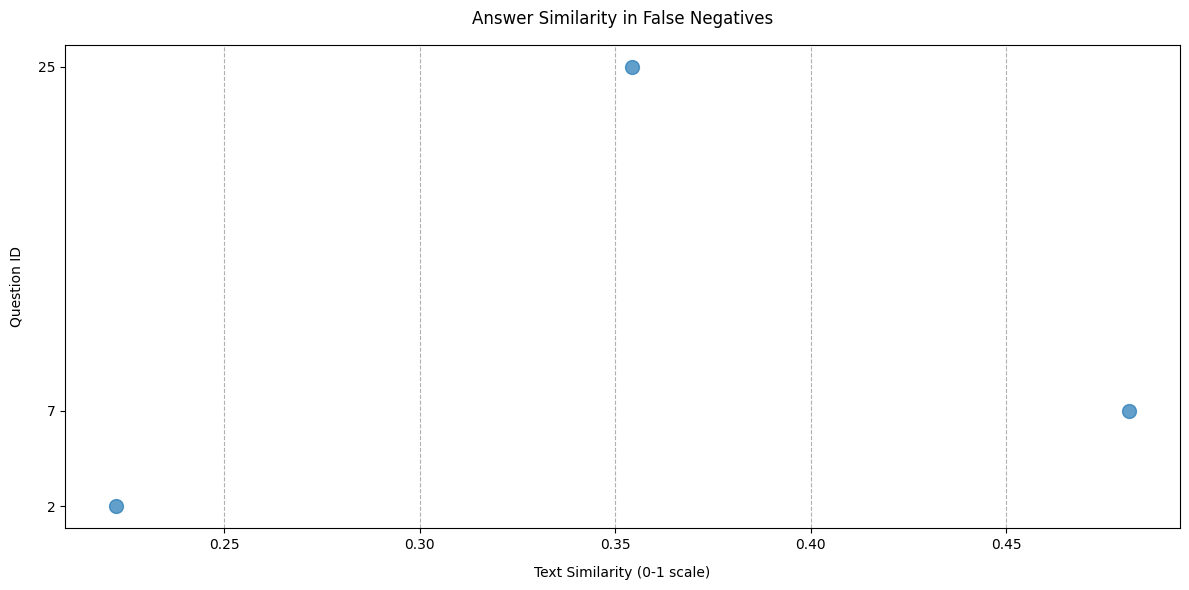

In [41]:
plt.figure(figsize=(10,6))
sns.barplot(
    x=['Added Qualifiers', 'Verbose Answers', 'Partial Matches'],
    y=[
        sum('always' in rag or 'never' in rag for _, rag, _ in false_negatives),
        sum(len(rag.split()) > 15 for _, rag, _ in false_negatives),
        sum(any(w in rag.lower() for w in truth.lower().split()) 
            for _, rag, truth in false_negatives)
    ],
    palette="viridis"
)
plt.title("False Negative Error Patterns", pad=20, fontsize=14)
plt.ylabel("Count", labelpad=10)
plt.xticks(rotation=15, ha='right')
sns.despine()
plt.tight_layout()
plt.show()

# Question-Level Similarity
similarities = []
for q_id, rag, truth in false_negatives:
    similarities.append({
        'Question': int(q_id.split('_')[1]),
        'Similarity': SequenceMatcher(None, rag.lower(), truth.lower()).ratio()
    })

df = pd.DataFrame(similarities).sort_values('Question')

plt.figure(figsize=(12,6))
plt.scatter(df['Similarity'], df['Question'], s=100, alpha=0.7)
plt.title("Answer Similarity in False Negatives", pad=15)
plt.xlabel("Text Similarity (0-1 scale)", labelpad=10)
plt.ylabel("Question ID", labelpad=10)
plt.yticks(df['Question'])
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()